# Interpolate data and concatenate streams

Raw Neon data is not always easy to work with. A data stream (e.g., gaze, eye states, IMU) might not have been sampled at a constant rate. Additionally, streams may have differing sampling rates and lack synchronized start timestamps. All of these issues add complexity to continuous data analysis and sensor fusion.

This tutorial demonstrates how to deal with these issues by interpolating data streams and concatenating them into a single DataFrame. We will use the same ``boardView`` dataset as in the [previous tutorial](read_recording.ipynb).

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from pyneon import Recording, get_sample_data

recording_dir = (
    get_sample_data("boardView")
    / "Timeseries Data + Scene Video"
    / "boardview1-d4fd9a27"
)

We now access raw data from gaze, eye states, and IMU streams.

In [2]:
rec = Recording(recording_dir)
gaze = rec.gaze
eye_states = rec.eye_states
imu = rec.imu

## Irregular sampling in data streams

Data points from each stream are indexed by `timestamp [ns]`, which denotes the Unix time of the sample in nanoseconds. Are these samples uniformly distributed over time? We can examine the initial samples from each stream to assess their distribution, where, due to device boot-up, the sampling may be irregular.

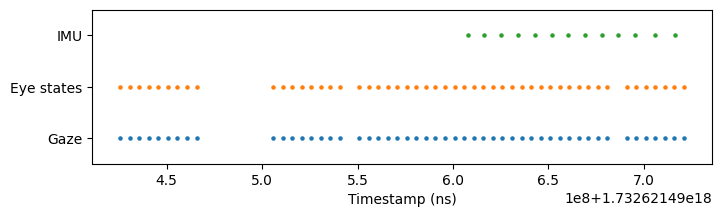

In [3]:
# Take the first 0.3 seconds of gaze data
gaze_begin = gaze.crop(0, 0.3, by="time")
# And the corresponding eye states and IMU data
eye_states_begin = eye_states.restrict(gaze_begin)
imu_begin = imu.restrict(gaze_begin)


# Define a function to plot the timestamps of the gaze, eye states, and IMU data
def plot_timestamps(gaze, eye_states, imu, concat_stream=None):
    _, ax = plt.subplots(figsize=(8, 2))
    ax.scatter(gaze.ts, np.ones_like(gaze.ts), s=5)
    ax.scatter(eye_states.ts, np.ones_like(eye_states.ts) * 2, s=5)
    ax.scatter(imu.ts, np.ones_like(imu.ts) * 3, s=5)
    # If a concatenated stream (explained later) is provided, plot its timestamps as well
    if concat_stream is not None:
        ax.scatter(concat_stream.ts, np.ones_like(concat_stream.ts) * 4, s=5)
        ax.set_yticks([1, 2, 3, 4])
        ax.set_yticklabels(["Gaze", "Eye states", "IMU", "Concatenated"])
        ax.set_ylim(0.5, 4.5)
    else:
        ax.set_yticks([1, 2, 3])
        ax.set_yticklabels(["Gaze", "Eye states", "IMU"])
        ax.set_ylim(0.5, 3.5)
    ax.set_xlabel("Timestamp (ns)")
    plt.show()


plot_timestamps(gaze_begin, eye_states_begin, imu_begin)

As shown in the figure above, in addition to the apparently later onset of IMU data, the first 0.3 second of gaze and eye states data indeed suffers from dropouts.

In addition to dropouts, irregular sampling may also occur, especially for IMU data from our experience. For example, it can be observed in the middle of this recording (5 - 5.3 seconds):

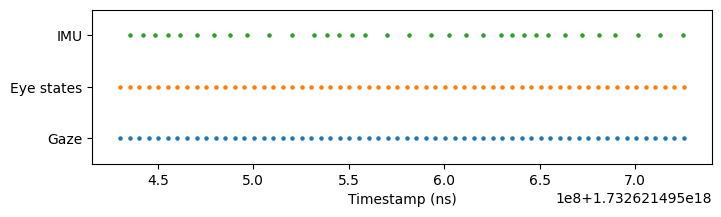

In [4]:
gaze_middle = gaze.crop(5, 5.3, by="time")
eye_states_middle = eye_states.restrict(gaze_middle)
imu_middle = imu.restrict(gaze_middle)

plot_timestamps(gaze_middle, eye_states_middle, imu_middle)

How frequent are these irregularities? We now examine the distribution of the time differences between consecutive samples, and compare them to the expected time difference for a regular, nominal (as specified by Pupil Labs) sampling rate.

Nominal sampling frequency of gaze: 200 Hz. Actual: 199.4 Hz
Nominal sampling frequency of eye states: 200 Hz. Actual: 199.4 Hz
Nominal sampling frequency of IMU: 110 Hz. Actual: 113.9 Hz


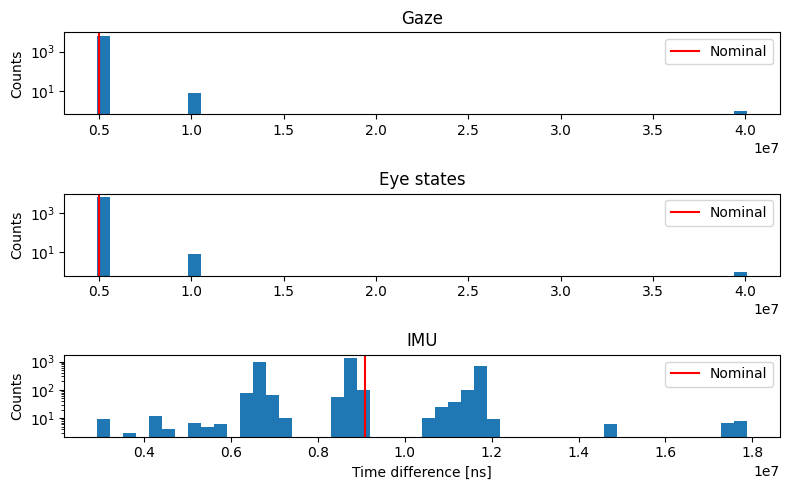

In [5]:
print(
    f"Nominal sampling frequency of gaze: {gaze.sampling_freq_nominal} Hz. "
    f"Actual: {gaze.sampling_freq_effective:.1f} Hz"
)
print(
    f"Nominal sampling frequency of eye states: {eye_states.sampling_freq_nominal} Hz. "
    f"Actual: {eye_states.sampling_freq_effective:.1f} Hz"
)
print(
    f"Nominal sampling frequency of IMU: {imu.sampling_freq_nominal} Hz. "
    f"Actual: {imu.sampling_freq_effective:.1f} Hz"
)

fig, axs = plt.subplots(3, 1, figsize=(8, 5), tight_layout=True)

axs[0].hist(gaze.ts_diff, bins=50)
axs[0].axvline(1e9 / gaze.sampling_freq_nominal, c="red", label="Nominal")
axs[0].set_title("Gaze")

axs[1].hist(eye_states.ts_diff, bins=50)
axs[1].axvline(1e9 / eye_states.sampling_freq_nominal, c="red", label="Nominal")
axs[1].set_title("Eye states")

axs[2].hist(imu.ts_diff, bins=50)
axs[2].axvline(1e9 / imu.sampling_freq_nominal, c="red", label="Nominal")
axs[2].set_title("IMU")
axs[2].set_xlabel("Time difference [ns]")

for i in range(3):
    axs[i].set_yscale("log")
    axs[i].set_ylabel("Counts")
    axs[i].legend()
plt.show()

For gaze and eye states data, the empirical distribution of time differences is close to the expected value. However, some integer multiples of the nominal sampling rate suggest possible eye video frame drops. For IMU data, the distribution is much wider.

## Interpolating data streams

Given the presence of irregular sampling, if you want to perform analyses that assume continuous data streams, interpolation is necessary. PyNeon uses the `scipy.interpolate.interp1d` [(API reference)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html) function to interpolate data streams. The `interpolate()` method of `Stream` creates a new object with interpolated data.

With the default parameters, the interpolated data will have the same start timestamp as the original data, and the sampling rate is set to the nominal sampling frequency specified by Pupil Labs (200 Hz for gaze and eye states, 110 Hz for IMU).

In [6]:
# Interpolate to the nominal sampling frequency
gaze_interp = gaze.interpolate()

# Three ways you can check if the interpolation was successful:
# 1. Compare the effective sampling frequency to the nominal sampling frequency
print(
    f"Nominal sampling frequency of gaze: {gaze_interp.sampling_freq_nominal} Hz. "
    f"Actual (after interpolation): {gaze_interp.sampling_freq_effective:.1f} Hz"
)
# 2. Check the number of unique time differences
print(f"Only one unique time difference: {np.unique(gaze_interp.ts_diff)}")
# 3. Call the `is_uniformly_sampled` property (boolean)
print(f"The new gaze stream is uniformly sampled: {gaze_interp.is_uniformly_sampled}")
print(gaze_interp.data.dtypes)

Nominal sampling frequency of gaze: 200 Hz. Actual (after interpolation): 200.0 Hz
Only one unique time difference: [5000000]
The new gaze stream is uniformly sampled: True
gaze x [px]        float64
gaze y [px]        float64
worn               float64
fixation id        float64
blink id           float64
azimuth [deg]      float64
elevation [deg]    float64
dtype: object


Note that after interpolation, the data types of the columns are preserved.

Alternatively, one can also interpolate the gaze data to any desired timestamps by specifying the `new_ts` parameter. This is especially helpful when synchronizing different data streams. For example, we can interpolate the gaze data (~200Hz) to the timestamps of the IMU data (~110Hz).

In [7]:
print(f"Original gaze data length: {len(gaze)}")
print(f"Original IMU data length: {len(imu)}")
gaze_interp_to_imu = gaze.interpolate(new_ts=imu.ts)
print(
    f"Gaze data length after interpolating to IMU timestamps: {len(gaze_interp_to_imu)}"
)

Original gaze data length: 6091
Original IMU data length: 3459
Gaze data length after interpolating to IMU timestamps: 3459


C:\Users\qian.chu\Documents\GitHub\PyNeon\pyneon\preprocess\preprocess.py:63: UserWarning: new_ts contains timestamps after the data end time; These samples will be NaN.
  warn(


By default, float-type data is interpolated using the `'linear'` method. We are examine its behavior by comparing interpolated data with the raw data.

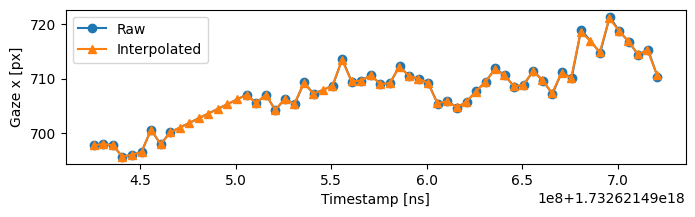

In [8]:
gaze_interp_begin = gaze_interp.restrict(gaze_begin)

plt.figure(figsize=(8, 2))
plt.plot(gaze_begin["gaze x [px]"], marker="o", label="Raw")
plt.plot(
    gaze_interp_begin["gaze x [px]"],
    marker="^",
    label="Interpolated",
)
plt.xlabel("Timestamp [ns]")
plt.ylabel("Gaze x [px]")
plt.legend()
plt.show()

## Concatenating different streams

There might be cases where you want to concatenate different streams into a single one to facilitate further analysis (e.g., [epoching](pupil_size_and_epoching.ipynb)). This is possible by interpolating the streams' data to common timestamps and concatenating them into a single DataFrame.

The method `concat_streams()` of `Recording` provides such functionality. It takes a list of stream names and interpolate them to common timestamps, defined by the latest start and earliest end timestamps of the streams. The new sampling frequency can either be directly specified or taken from the lowest/highest sampling frequency of the streams.

In the following example, we concatenate the gaze, eye states, and IMU streams into a single DataFrame using the default parameters.

In [9]:
concat_stream = rec.concat_streams(["gaze", "eye_states", "imu"])
print(concat_stream.data.head())
print(concat_stream.data.columns)

Concatenating streams:
	gaze
	eye_states
	imu
Using lowest sampling rate: 110 Hz (['imu'])
Using latest start timestamp: 1732621490607650343 (['imu'])
Using earliest last timestamp: 1732621520979070343 (['gaze' 'eye_states'])
                     gaze x [px]  gaze y [px]  worn  fixation id  blink id  \
timestamp [ns]                                                               
1732621490607650343   705.518843   554.990998     1            1      <NA>   
1732621490616741252   704.882466   553.793144     1            1      <NA>   
1732621490625832161   707.703787   556.712159     1            1      <NA>   
1732621490634923070   711.389879   553.846843     1            1      <NA>   
1732621490644013979   709.281775   555.543777     1            1      <NA>   

                     azimuth [deg]  elevation [deg]  pupil diameter left [mm]  \
timestamp [ns]                                                                  
1732621490607650343      -7.085339         3.473196              

We show an exemplary sampling of eye, imu and concatenated data below. It can be seen that the concatenated data is regularly sampled at the nominal sampling rate of IMU.

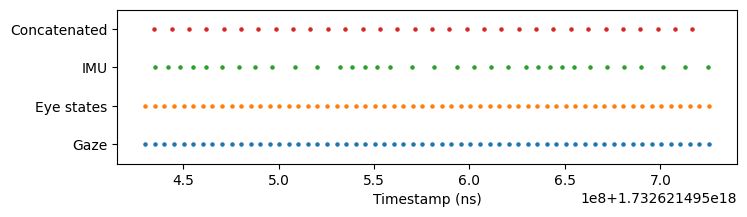

In [10]:
concat_stream_middle = concat_stream.restrict(gaze_middle)
plot_timestamps(gaze_middle, eye_states_middle, imu_middle, concat_stream_middle)

Despite different sampling from the original streams, the concatenated data still respects the original values of the data. For example, the `gaze x [px]` and `acceleration x [g]` data from the raw and concatenated stream are quite comparable.

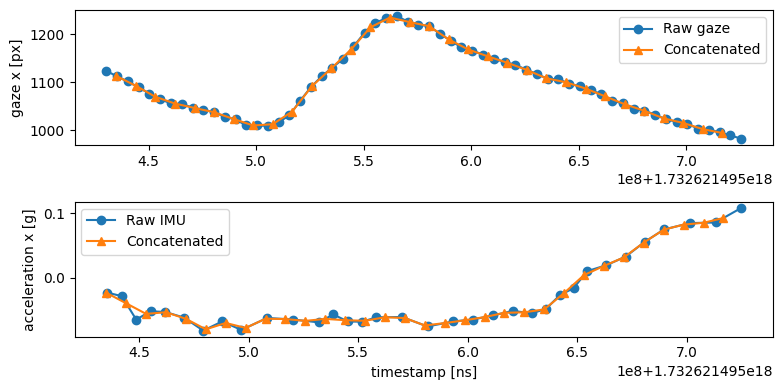

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(8, 4), tight_layout=True)
axs[0].plot(
    gaze_middle["gaze x [px]"],
    marker="o",
    label="Raw gaze",
)
axs[0].plot(
    concat_stream_middle["gaze x [px]"],
    marker="^",
    label="Concatenated",
)
axs[0].set_ylabel("gaze x [px]")
axs[0].legend()
axs[1].plot(
    imu_middle["acceleration x [g]"],
    marker="o",
    label="Raw IMU",
)
axs[1].plot(
    concat_stream_middle["acceleration x [g]"],
    marker="^",
    label="Concatenated",
)
axs[1].set_ylabel("acceleration x [g]")
axs[1].set_xlabel("timestamp [ns]")
axs[1].legend()
plt.show()